<a href="https://colab.research.google.com/github/JulietteMaes01/University-Projects/blob/main/Assignment2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 23.4 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torchvision.datasets
import torch.optim as optim
import torch.utils.data as utils
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import shutil
from google.colab import files

from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
from tqdm import tqdm

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import pandas as pd
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from google.colab.patches import cv2_imshow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the dataset by pointing to the FER2013 csv file
path = r'/content/drive/MyDrive/Deep Learning - faces/fer2013/fer2013/fer2013.csv'
df = pd.read_csv(path)
df.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

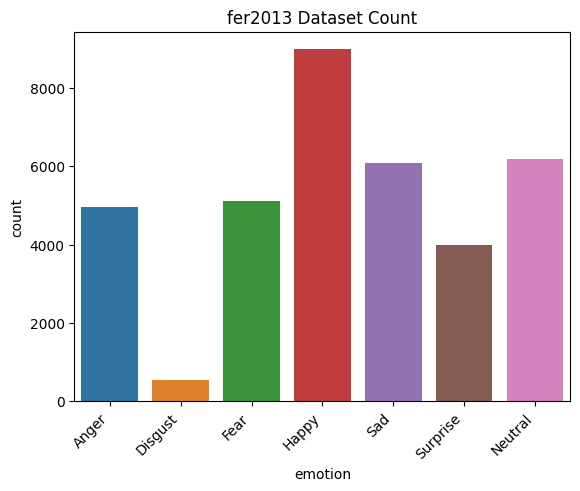

In [ ]:
# Define dictionary of output to description
emotion_labels = {0:'Anger', 1:'Disgust', 2:'Fear',3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

# Display dataset distribution
ax = sns.countplot(x=df['emotion'])
ax.set_xticklabels(emotion_labels.values(), rotation=45, ha='right')
ax.set(title="fer2013 Dataset Count")
plt.show()

In [ ]:
# I am just going to try this first
X = df['pixels'].values
y = df['emotion'].values

X = np.array([np.fromstring(x, dtype=int, sep=' ') for x in X])
X = X/255.0 # normalizing the pixel values to [0,1]
X = X.reshape(-1,1,48,48)

X_train = X[df['Usage'] == 'Training']
y_train = y[df['Usage'] == 'Training']
X_valid = X[df['Usage'] == 'PublicTest']
y_valid = y[df['Usage'] == 'PublicTest']
X_test = X[df['Usage'] == 'PrivateTest']
y_test = y[df['Usage'] == 'PrivateTest']

print("Training set size:", len(X_train))
print("Validation set size:", len(X_valid))
print("Test set size:", len(X_test))

Training set size: 28709
Validation set size: 3589
Test set size: 3589


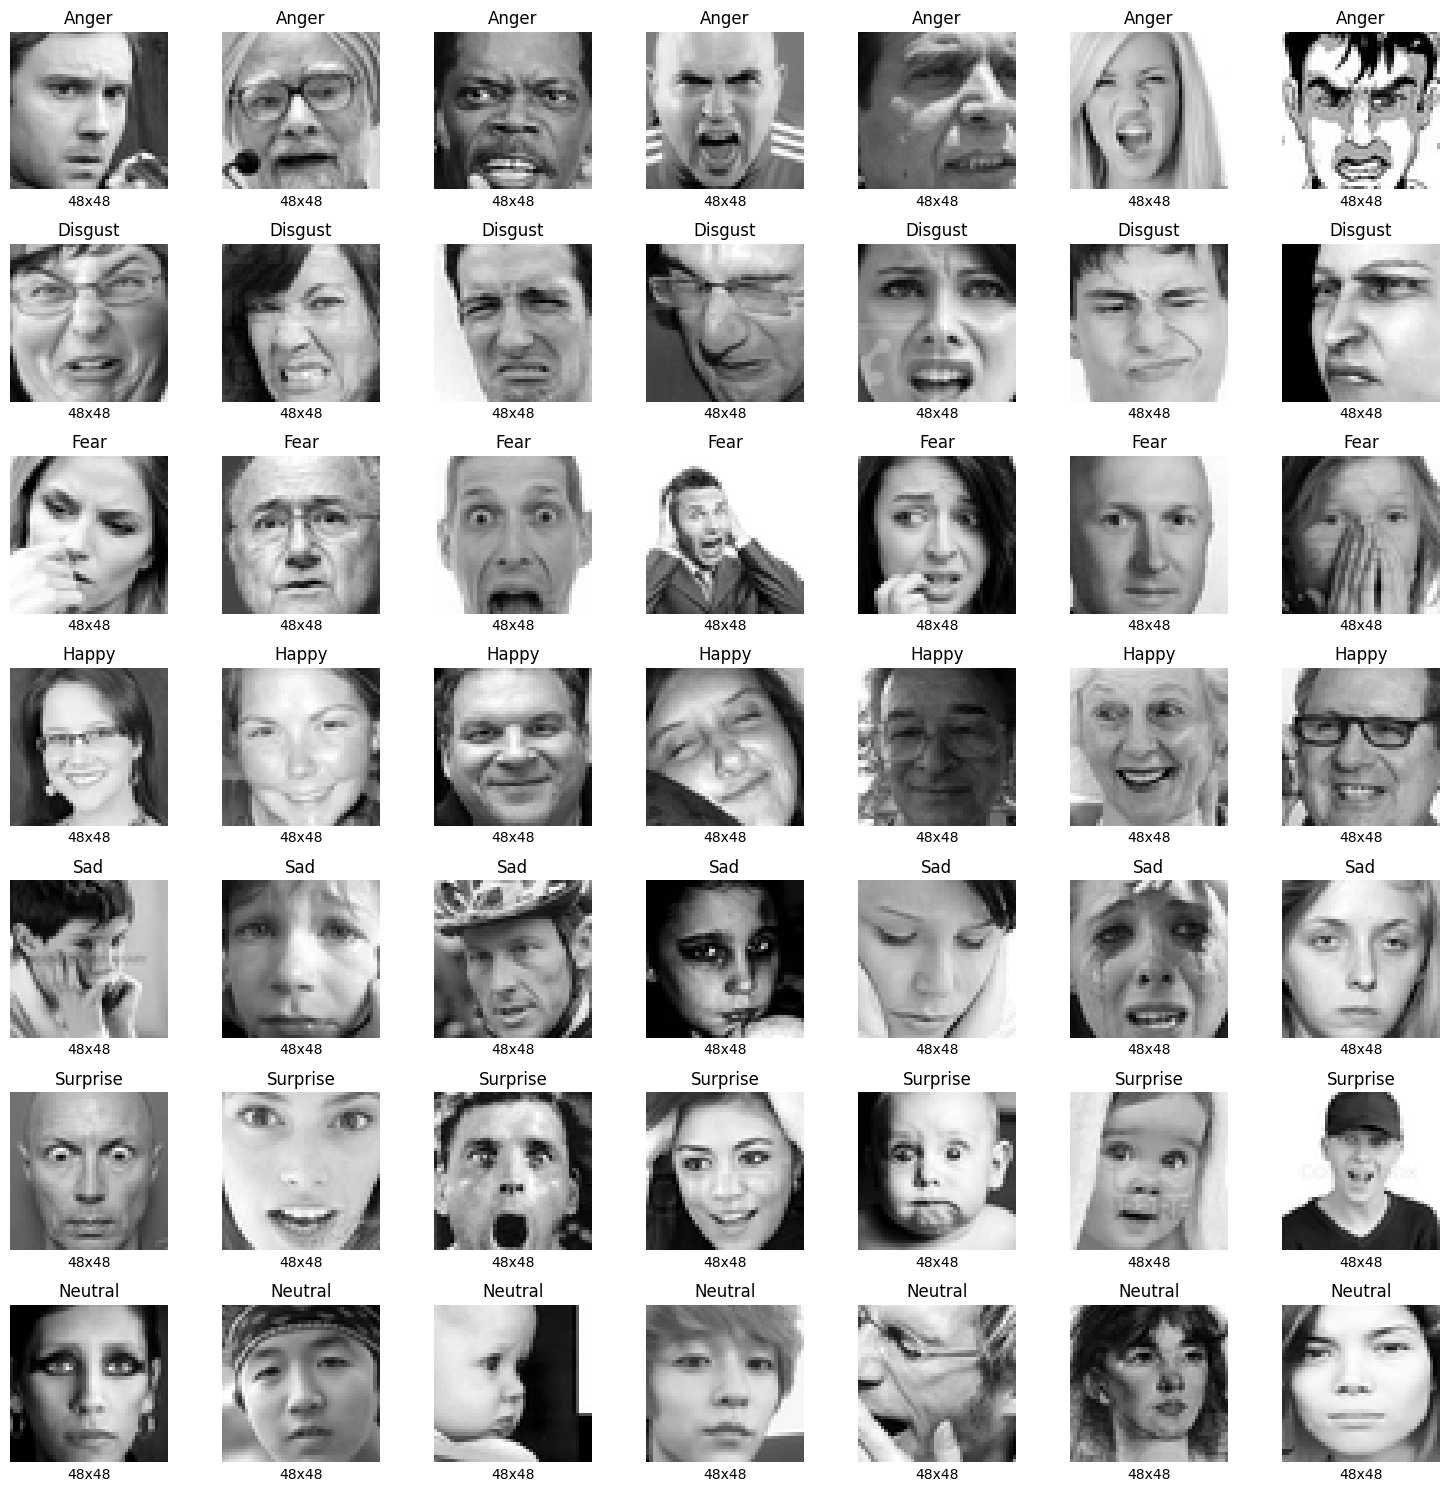

In [ ]:
# let us look at some sample faces per emotion
fig, axes = plt.subplots(len(emotion_labels), 7, figsize=(15,15))

for i, emotion in enumerate(emotion_labels):
    indices = np.where(y_train == i)[0][:7]

    for j, index in enumerate(indices):
        ax = axes[i, j]
        ax.imshow(X_train[index].squeeze(), cmap='gray')
        ax.set_title(emotion_labels[i])
        ax.axis('off')
        image_dimensions = f'{X_train[index].shape[1]}x{X_train[index].shape[2]}'
        ax.text(0.5, -0.1, image_dimensions, transform=ax.transAxes, ha='center')




plt.tight_layout()
plt.show()

In [ ]:
# convert data intor tensors
tensor_x = torch.stack([torch.Tensor(i) for i in X_train])
tensor_y = torch.tensor(y_train, dtype=torch.long)
train_data = utils.TensorDataset(tensor_x, tensor_y)

tensor_x = torch.stack([torch.Tensor(i) for i in X_valid])
tensor_y = torch.tensor(y_valid, dtype=torch.long)
valid_data = utils.TensorDataset(tensor_x, tensor_y)

tensor_x = torch.stack([torch.Tensor(i) for i in X_test])
tensor_y = torch.tensor(y_test, dtype=torch.long)
test_data = utils.TensorDataset(tensor_x, tensor_y)

batchsize = 64
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True) # we introduce some randomness to avoid potnetial bias, reduce overfitting
valid_loader = DataLoader(valid_data, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False)

# train_steps = len(train_loader.dataset) // batchsize        # -> 448
# valid_steps = len(valid_loader.dataset) // batchsize        # -> 56
# test_steps = len(test_loader.dataset) // batchsize           # -> 56

In [ ]:
#LpM



# class ConfigurableEmotionCNN(nn.Module):
#     def __init__(self, num_of_conv_layers, num_input_channels, num_of_fc_layers):
#         super(ConfigurableEmotionCNN, self).__init__()
#         self.num_of_conv_layers = num_of_conv_layers
#         self.num_of_fc_layers = num_of_fc_layers

#         self.conv = nn.ModuleList()
#         self.relu = nn.ModuleList()
#         self.maxpool = nn.ModuleList()
#         self.fc = nn.ModuleList()

#         # Configure convolutions
#         for i in range(num_of_conv_layers):
#             in_channels = num_input_channels if i == 0 else 32 * i
#             out_channels = 32 * (i + 1)
#             self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
#             self.relu.append(nn.ReLU())
#             self.maxpool.append(nn.MaxPool2d(kernel_size=2, stride=2))

#         # Get the output size after the last convolutional layer
#         dummy_input = torch.randn(1, num_input_channels, 48, 48)  # Adjust input size if needed
#         out = self.forward_conv(dummy_input)
#         out_shape = out.shape

#         # Calculate the correct input size for fully connected layers
#         self.fc_input_size = out_shape[1] * out_shape[2] * out_shape[3]

#         # Configure fully connected layers
#         in_features = self.fc_input_size
#         for i in range(num_of_fc_layers):
#             out_features = 7 if i == (num_of_fc_layers - 1) else (num_of_fc_layers - i) * 128
#             self.fc.append(nn.Linear(in_features, out_features))
#             in_features = out_features

#         # Print the CNN structure
#         self.print_structure()

#     def forward(self, x):
#         out = self.forward_conv(x)
#         out = self.forward_fc(out)
#         return out

#     def forward_conv(self, x):
#         out = x
#         for i in range(self.num_of_conv_layers):
#             out = self.conv[i](out)
#             out = self.relu[i](out)
#             out = self.maxpool[i](out)
#         return out

#     def forward_fc(self, x):
#         out_shape = x.shape
#         out = x.view(out_shape[0], -1)
#         for i in range(self.num_of_fc_layers):
#             out = self.fc[i](out)
#             if i != self.num_of_fc_layers - 1:
#                 out = torch.relu(out)
#         return out

#     def print_structure(self):
#         print("CNN Structure:")
#         print("----------------")
#         print("Convolutional Layers:")
#         for i in range(self.num_of_conv_layers):
#             print("Conv layer", i, "input", 32 * i if i > 0 else 1, "output", 32 * (i + 1))
#         print("----------------")
#         print("Fully Connected Layers:")
#         for i in range(self.num_of_fc_layers):
#             print("Fc layer", i, "input", self.fc_input_size if i == 0 else (self.num_of_fc_layers - i) * 128, "output", 7 if i == self.num_of_fc_layers - 1 else (self.num_of_fc_layers - i) * 128)

class ConfigurableEmotionCNN(nn.Module):
    def __init__(self, num_of_conv_layers, num_input_channels, num_of_fc_layers):
        super(ConfigurableEmotionCNN, self).__init__()
        self.num_of_conv_layers = num_of_conv_layers
        self.num_of_fc_layers = num_of_fc_layers
        self.num_input_channels = num_input_channels

        self.conv = nn.ModuleList()
        self.relu = nn.ModuleList()
        self.maxpool = nn.ModuleList()
        self.fc = nn.ModuleList()

        # Configure convolutions
        in_channels = num_input_channels
        out_channels = 32
        for i in range(num_of_conv_layers):
            self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.relu.append(nn.ReLU())
            self.maxpool.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels
            out_channels *= 2

        # Get the output size after the last convolutional layer
        dummy_input = torch.randn(1, num_input_channels, 48, 48)  # Adjust input size if needed
        out = self.forward_conv(dummy_input)
        out_shape = out.shape

        # Calculate the correct input size for fully connected layers
        self.fc_input_size = out_shape[1] * out_shape[2] * out_shape[3]

        # Configure fully connected layers
        in_features = self.fc_input_size
        for i in range(num_of_fc_layers):
            out_features = 7 if i == (num_of_fc_layers - 1) else (num_of_fc_layers - i) * 128
            self.fc.append(nn.Linear(in_features, out_features))
            in_features = out_features

        # Print the CNN structure
        self.print_structure()

    def forward(self, x):
        out = self.forward_conv(x)
        out = self.forward_fc(out)
        return out

    def forward_conv(self, x):
        out = x
        for i in range(self.num_of_conv_layers):
            out = self.conv[i](out)
            out = self.relu[i](out)
            out = self.maxpool[i](out)
        return out

    def forward_fc(self, x):
        out_shape = x.shape
        out = x.view(out_shape[0], -1)
        for i in range(self.num_of_fc_layers):
            out = self.fc[i](out)
            if i != self.num_of_fc_layers - 1:
                out = torch.relu(out)
        return out

    def print_structure(self):
        print("CNN Structure:")
        print("----------------")
        print("Convolutional Layers:")
        for i in range(self.num_of_conv_layers):
            print("Conv layer", i, "input", self.conv[i].in_channels, "output", self.conv[i].out_channels)
        print("----------------")
        print("Fully Connected Layers:")
        for i in range(self.num_of_fc_layers):
            print("Fc layer", i, "input", self.fc[i].in_features, "output", self.fc[i].out_features)




In [ ]:
#set some basics
destination_folder = r'/content/drive/MyDrive/Deep Learning - faces/'

In [ ]:
def buildAndTrainModel(trainingDataLoader,epochs,learning_rate, numOfConLayers, numOfFcLayers, verbose=True):
		# setup for training
		#epochs = 100  # we'll make that configurable
		#batch_size = 64
		#learning_rate = 0.01
		#numOfConLayers = 2
		#numOfFcLayers = 2

		model = ConfigurableEmotionCNN(numOfConLayers, 1,numOfFcLayers)
		device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		if (verbose): print(device)
		model.to(device)
		criterion = nn.CrossEntropyLoss()
		optimizer_Adam = optim.Adam(model.parameters(), lr = learning_rate)
		optimizer_SGD = optim.SGD(model.parameters(), lr = learning_rate)

		if (verbose): print("[INFO] training the network...")
		startTime = time.time()
		#print(model)


		# loop over our epochs
		for e in range(epochs):
			# set the model in training mode
			if (verbose): print('Training epoch ',e)
			startTimeEpoch = time.time()
			model.train()
			# initialize the total training and validation loss
			totalTrainLoss = 0
			totalValLoss = 0
			# initialize the number of correct predictions in the training
			# and validation step
			trainCorrect = 0
			valCorrect = 0
			# loop over the training set
			for i,(images, labels) in enumerate(trainingDataLoader):
				# send the input to the device
				(images, labels) = (images.to(device), labels.to(device))
				#lemon juice
				labels = labels.squeeze()
				# perform a forward pass and calculate the training loss
				optimizer_Adam.zero_grad()  #reset the gradients of the optimizer (new batch)
				prediction = model(images)
				loss = criterion(prediction, labels.long())
				# zero out the gradients, perform the backpropagation step,
				# and update the weights
				optimizer_Adam.zero_grad()
				loss.backward()
				optimizer_Adam.step()
				# add the loss to the total training loss so far and
				# calculate the number of correct predictions
				totalTrainLoss += loss
				trainCorrect += (prediction.argmax(1) == labels).type(torch.float).sum().item()
			endTimeEpoch = time.time()
			elapsedEpoch = endTimeEpoch - startTimeEpoch
			if (verbose): print('Took ',elapsedEpoch)

		endTime = time.time()
		elapsed = endTime - startTime
		if (verbose): print('Training took ', elapsed, " seconds")

	#let's return a structure with the needed info (model, elapsed)
		return model, elapsed



In [ ]:
def evaluateModel(model, validationDataLoader, verbose=True):
			# switch off autograd for evaluation
			# set the model in evaluation mode
			device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
			if (verbose): print(device)
			model.to(device)

			model.eval()
			with torch.no_grad():
				correct = 0
				total = 0
				if (verbose): print('Now evaluating...')
				# loop over the validation set
				for (images, labels) in validationDataLoader:
					# send the input to the device
					(images, labels) = (images.to(device), labels.to(device))
					# make the predictions and calculate the validation loss
					pred = model(images)

					_, prediction = torch.max(pred.data,1)
					# increment nuber of samples
					total += labels.size(0)
					#increment correct if prediction was fine
					correct += (prediction==labels).sum().item()
					# totalValLoss += lossFn(pred, y)
					# # calculate the number of correct predictions
					# valCorrect += (pred.argmax(1) == y).type(
					# 	torch.float).sum().item()


			accuracy = correct / total
			precision = precision_score(labels.cpu().numpy(), prediction.cpu().numpy(), average='macro')
			recall = recall_score(labels.cpu().numpy(), prediction.cpu().numpy(), average='macro')
			f1 = f1_score(labels.cpu().numpy(), prediction.cpu().numpy(), average='macro')

			output = {'Accuracy': accuracy,
									'Precision': precision,
									'Recall': recall,
									'F1': f1
									}
			if (verbose):
				print("Validation Accuracy: {:.2%}".format(accuracy))
				print("Validation Precision: {:.2%}".format(precision))
				print("Validation Recall: {:.2%}".format(recall))
				print("Validation F1 Score: {:.2%}".format(f1))
			return output



In [ ]:
#this is where we will run all our scenarii (CNN architectures - Conv Leyers, FC layers,... - / number of training epochs / ...)

#create a panda dataframe to store the statictics
df = pd.DataFrame(columns=['Elapsed','Epochs', 'Learning_Rate', 'NumOfCOnv', 'NumOfFc','Accuracy','Precision','Recall','F1'])

layers = [[2,2], [3,2], [5,2], [5, 5]]

epochList = [50, 100]
lrList = [0.1, 0.01, 0.001]

for epoch in epochList:
  for lr in lrList:
    for layer in layers:
      numOfConLayers = layer[0]
      numOfFcLayers = layer[1]
      model, elapsed = buildAndTrainModel(train_loader,epoch,lr,numOfConLayers,numOfFcLayers,False)

      print("Elapsed ", elapsed)
      path = destination_folder+'configurable_model_'+str(epoch)+"_"+str(lr)+"_"+str(numOfConLayers)+"_"+str(numOfFcLayers)+".pth"
      torch.save(model, path)
      print("Model saved successfully. ", epoch, lr, numOfConLayers, numOfFcLayers)

      evaluation = evaluateModel(model,valid_loader)
      #and write to a file
      #should be done to a panda dataframe so that a single .csv can be exported
      with open(destination_folder+"stats_"+str(epoch)+"_"+str(lr)+"_"+str(numOfConLayers)+"_"+str(numOfFcLayers)+".txt", "w") as file:
        print("Elapsed: ", elapsed, file=file)
        print("Number of Epochs: ", epoch, file=file)
        print("Rate of learning: ", lr, file=file)
        print("Number of conv layers: ",numOfConLayers, file=file)
        print("Number of fully connected layers: ",numOfFcLayers, file=file)
        print("Validation Accuracy: {:.2%}".format(evaluation['Accuracy']), file=file)
        print("Validation Precision: {:.2%}".format(evaluation['Precision']), file=file)
        print("Validation Recall: {:.2%}".format(evaluation['Recall']), file=file)
        print("Validation F1 Score: {:.2%}".format(evaluation['F1']), file=file)
      #store in pandas dataframe to save later to excel
      #deprecated soon df = df.append({'Epochs' : epoch, 'Learning_Rate' : lr , 'NumOfConv' : numOfConLayers, 'NumOfFc' : numOfFcLayers,'Accuracy' : evaluation['Accuracy'],'Precision' : evaluation['Precision'],'Recall' : evaluation['Recall'],'F1' : evaluation['F1']}, ignore_index=True)
      new_row = {'Elapsed': elapsed,'Epochs': epoch, 'Learning_Rate': lr, 'NumOfConv': numOfConLayers, 'NumOfFc': numOfFcLayers, 'Accuracy': evaluation['Accuracy'], 'Precision': evaluation['Precision'], 'Recall': evaluation['Recall'], 'F1': evaluation['F1']}
      new_df = pd.DataFrame([new_row])
      df = pd.concat([df, new_df], ignore_index=True)

      torch.save(model, destination_folder+'evaluated_model_'+str(epoch)+"_"+str(lr)+"_"+str(numOfConLayers)+"_"+str(numOfFcLayers)+'.pth')
      print("Evaluated model saved successfully.")
      df.to_excel(destination_folder+'ModelStats.xlsx', index=False)
      print('Stats saved to Excel ')


CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
----------------
Fully Connected Layers:
Fc layer 0 input 9216 output 256
Fc layer 1 input 256 output 7
Elapsed  273.3107604980469
Model saved successfully.  100 0.1 2 2
cuda
Now evaluating...
Validation Accuracy: 24.94%
Validation Precision: 10.00%
Validation Recall: 50.00%
Validation F1 Score: 16.67%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
Conv layer 2 input 64 output 128
----------------
Fully Connected Layers:
Fc layer 0 input 4608 output 256
Fc layer 1 input 256 output 7
Elapsed  274.03200936317444
Model saved successfully.  100 0.1 3 2
cuda
Now evaluating...
Validation Accuracy: 24.94%
Validation Precision: 10.00%
Validation Recall: 50.00%
Validation F1 Score: 16.67%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
Conv layer 2 input 64 output 128
Conv layer 3 input 128 output 256
Conv layer 4 input 256 output 512
----------------
Fully Connected Layers:
Fc layer 0 input 512 output 256
Fc layer 1 input 256 output 7
Elapsed  373.4511013031006
Model saved successfully.  100 0.1 5 2
cuda
Now evaluating...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 24.94%
Validation Precision: 10.00%
Validation Recall: 50.00%
Validation F1 Score: 16.67%
Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
Conv layer 2 input 64 output 128
Conv layer 3 input 128 output 256
Conv layer 4 input 256 output 512
----------------
Fully Connected Layers:
Fc layer 0 input 512 output 640
Fc layer 1 input 640 output 512
Fc layer 2 input 512 output 384
Fc layer 3 input 384 output 256
Fc layer 4 input 256 output 7
Elapsed  398.4123170375824
Model saved successfully.  100 0.1 5 5
cuda
Now evaluating...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 24.94%
Validation Precision: 10.00%
Validation Recall: 50.00%
Validation F1 Score: 16.67%
Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
----------------
Fully Connected Layers:
Fc layer 0 input 9216 output 256
Fc layer 1 input 256 output 7
Elapsed  250.58440375328064
Model saved successfully.  100 0.01 2 2
cuda
Now evaluating...
Validation Accuracy: 39.40%
Validation Precision: 50.00%
Validation Recall: 41.67%
Validation F1 Score: 35.56%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
Conv layer 2 input 64 output 128
----------------
Fully Connected Layers:
Fc layer 0 input 4608 output 256
Fc layer 1 input 256 output 7
Elapsed  274.1890938282013
Model saved successfully.  100 0.01 3 2
cuda
Now evaluating...
Validation Accuracy: 40.71%
Validation Precision: 50.00%
Validation Recall: 37.50%
Validation F1 Score: 41.67%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
Conv layer 2 input 64 output 128
Conv layer 3 input 128 output 256
Conv layer 4 input 256 output 512
----------------
Fully Connected Layers:
Fc layer 0 input 512 output 256
Fc layer 1 input 256 output 7
Elapsed  375.19084191322327
Model saved successfully.  100 0.01 5 2
cuda
Now evaluating...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 40.09%
Validation Precision: 50.00%
Validation Recall: 50.00%
Validation F1 Score: 44.44%
Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
Conv layer 2 input 64 output 128
Conv layer 3 input 128 output 256
Conv layer 4 input 256 output 512
----------------
Fully Connected Layers:
Fc layer 0 input 512 output 640
Fc layer 1 input 640 output 512
Fc layer 2 input 512 output 384
Fc layer 3 input 384 output 256
Fc layer 4 input 256 output 7
Elapsed  398.9356064796448
Model saved successfully.  100 0.01 5 5
cuda
Now evaluating...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 24.94%
Validation Precision: 10.00%
Validation Recall: 50.00%
Validation F1 Score: 16.67%
Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
----------------
Fully Connected Layers:
Fc layer 0 input 9216 output 256
Fc layer 1 input 256 output 7
Elapsed  253.09927988052368
Model saved successfully.  100 0.001 2 2
cuda
Now evaluating...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 53.50%
Validation Precision: 40.00%
Validation Recall: 25.00%
Validation F1 Score: 28.00%
Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
Conv layer 2 input 64 output 128
----------------
Fully Connected Layers:
Fc layer 0 input 4608 output 256
Fc layer 1 input 256 output 7
Elapsed  276.213032245636
Model saved successfully.  100 0.001 3 2
cuda
Now evaluating...
Validation Accuracy: 54.33%
Validation Precision: 50.00%
Validation Recall: 37.50%
Validation F1 Score: 41.67%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
Conv layer 2 input 64 output 128
Conv layer 3 input 128 output 256
Conv layer 4 input 256 output 512
----------------
Fully Connected Layers:
Fc layer 0 input 512 output 256
Fc layer 1 input 256 output 7
Elapsed  380.11525225639343
Model saved successfully.  100 0.001 5 2
cuda
Now evaluating...
Validation Accuracy: 55.42%
Validation Precision: 25.00%
Validation Recall: 25.00%
Validation F1 Score: 25.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluated model saved successfully.
Stats saved to Excel 
CNN Structure:
----------------
Convolutional Layers:
Conv layer 0 input 1 output 32
Conv layer 1 input 32 output 64
Conv layer 2 input 64 output 128
Conv layer 3 input 128 output 256
Conv layer 4 input 256 output 512
----------------
Fully Connected Layers:
Fc layer 0 input 512 output 640
Fc layer 1 input 640 output 512
Fc layer 2 input 512 output 384
Fc layer 3 input 384 output 256
Fc layer 4 input 256 output 7
Elapsed  403.31888461112976
Model saved successfully.  100 0.001 5 5
cuda
Now evaluating...
Validation Accuracy: 50.77%
Validation Precision: 20.00%
Validation Recall: 20.00%
Validation F1 Score: 20.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluated model saved successfully.
Stats saved to Excel 


# Testing the models SGD versus ADAM

In [ ]:

model = torch.load(destination_folder+'evaluated_model_100_0.001_5_2.pth')
print("[INFO] Testing network...")
model.eval()
preds = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds.extend(outputs.argmax(axis=1).cpu().numpy())

    true_labels = test_data[:][1].cpu().numpy()
    report = classification_report(true_labels, np.array(preds), target_names=emotion_labels.values())
    print(report)

[INFO] Testing network...
              precision    recall  f1-score   support

       Anger       0.51      0.44      0.47       491
     Disgust       0.54      0.58      0.56        55
        Fear       0.44      0.41      0.43       528
       Happy       0.72      0.79      0.75       879
         Sad       0.43      0.43      0.43       594
    Surprise       0.76      0.70      0.73       416
     Neutral       0.52      0.55      0.54       626

    accuracy                           0.57      3589
   macro avg       0.56      0.56      0.56      3589
weighted avg       0.57      0.57      0.57      3589



# Video recognition

In [ ]:

def recogniseVideo(path):
    # Load the pre-trained face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Load the pre-trained emotion recognition model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    emotion_model = torch.load(destination_folder+'evaluated_model_100_0.001_5_2.pth')
    emotion_model.eval()

    emotion_model.to(device)

    #Load the video
    # Path to the video file
    video_path = path

    # Create a video capture object
    cap = cv2.VideoCapture(video_path)


    # Array to store the extracted face images
    face_images = []

    # List of emotion labels
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    frameNo = 0

    while cap.isOpened():
        # Read a frame from the video capture
        ret, frame = cap.read()
        if (frame is None):
          break

        frameNo +=1

        # Convert the frame to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Perform face detection
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Clear the face images array for each frame
        face_images = []

        # Process each detected face
        for (x, y, w, h) in faces:
            # Extract the face region from the frame
            face_img = frame[y:y+h, x:x+w]

            # Resize the face image to 48x48 pixels
            resized_face = cv2.resize(face_img, (48, 48))

            # Convert the resized face image to grayscale
            grayscale_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)

            # Append the grayscale face image to the array
            face_images.append(grayscale_face)

        # Draw bounding boxes around the detected faces and print the recognized emotion
        for i, (x, y, w, h) in enumerate(faces):
            # Get the corresponding face image from the array
            face_image = face_images[i]

            # Preprocess the face image for emotion recognition
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
            preprocessed_face = transform(face_image)
            preprocessed_face = preprocessed_face.unsqueeze(0)

            # Move the preprocessed face image to the same device as the model
            preprocessed_face = preprocessed_face.to(device)

            # Pass the preprocessed face image through the emotion recognition model
            with torch.no_grad():
                output = emotion_model(preprocessed_face)
                _, predicted = torch.max(output, 1)
                emotion = emotion_labels[predicted.item()]

            # Draw the bounding box and print the recognized emotion
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

        if (frameNo % 24 == 0):
            # Display the frame with bounding boxes
            print('show frame')

            cv2_imshow(frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

Gregoire
show frame


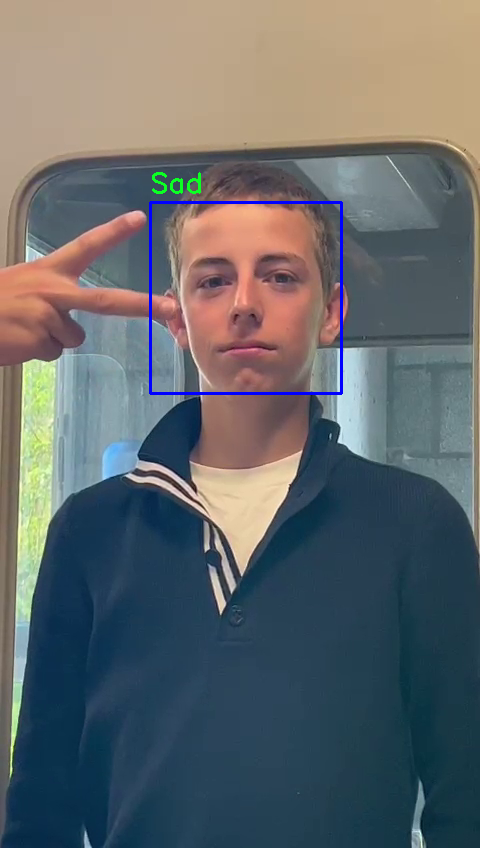

show frame


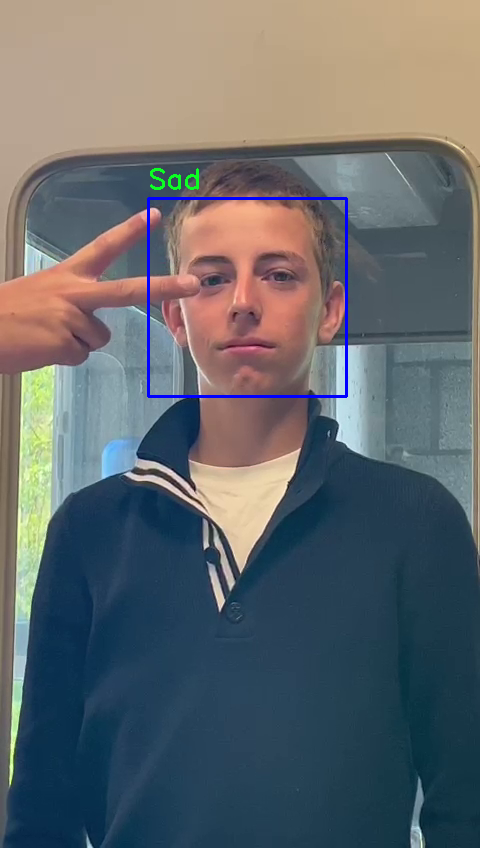

show frame


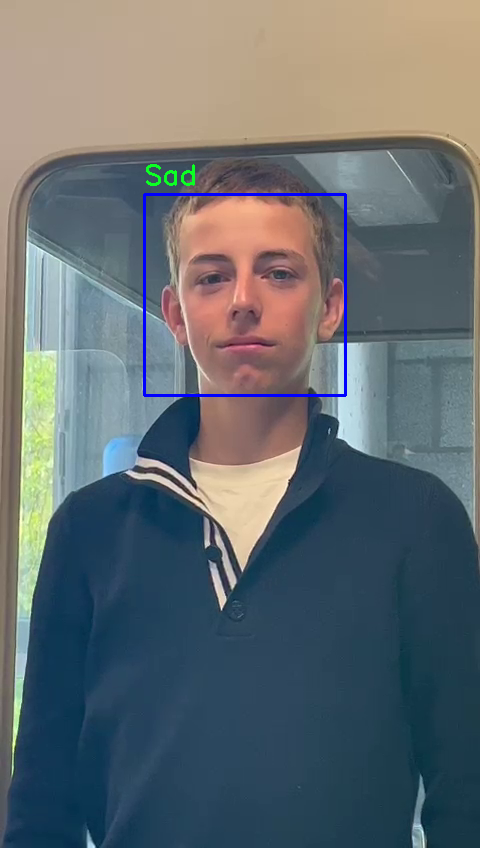

show frame


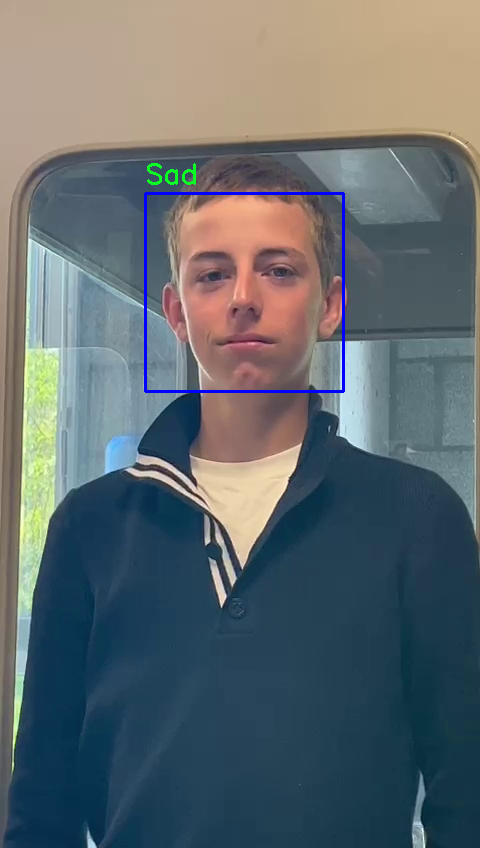

show frame


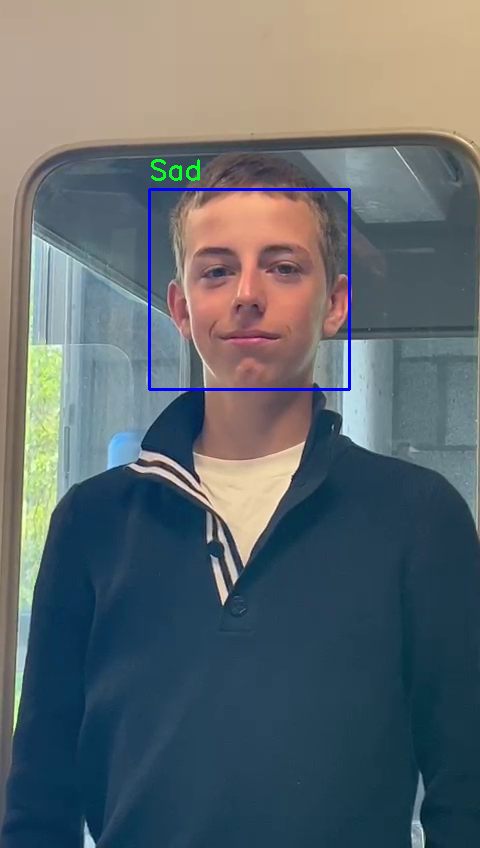

show frame


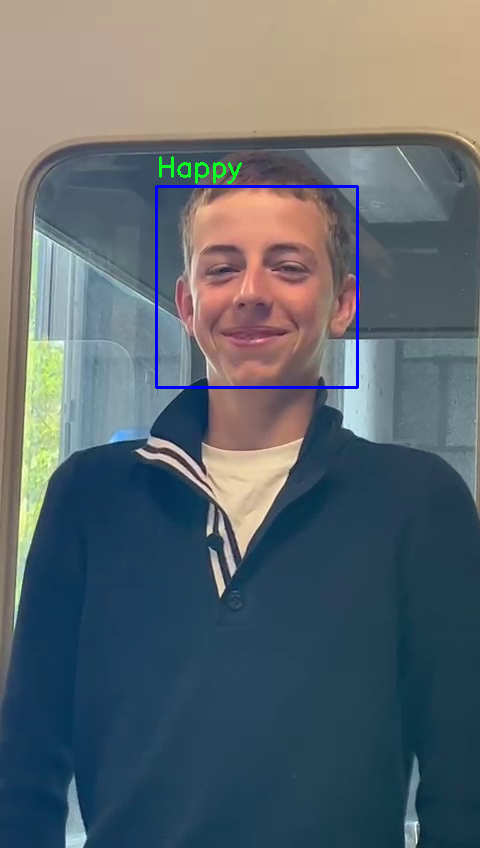

Charles
show frame


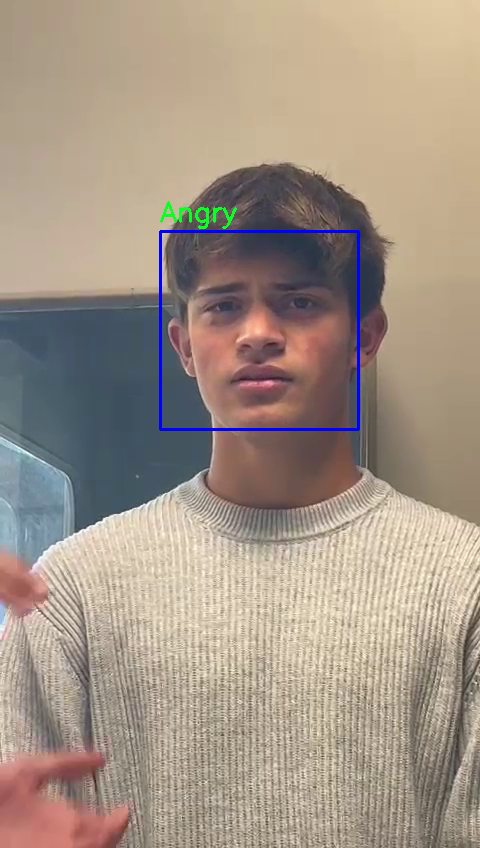

show frame


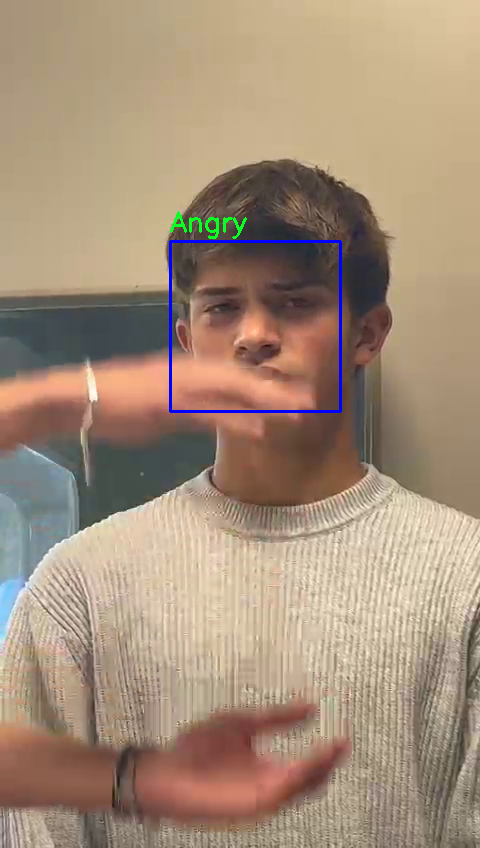

show frame


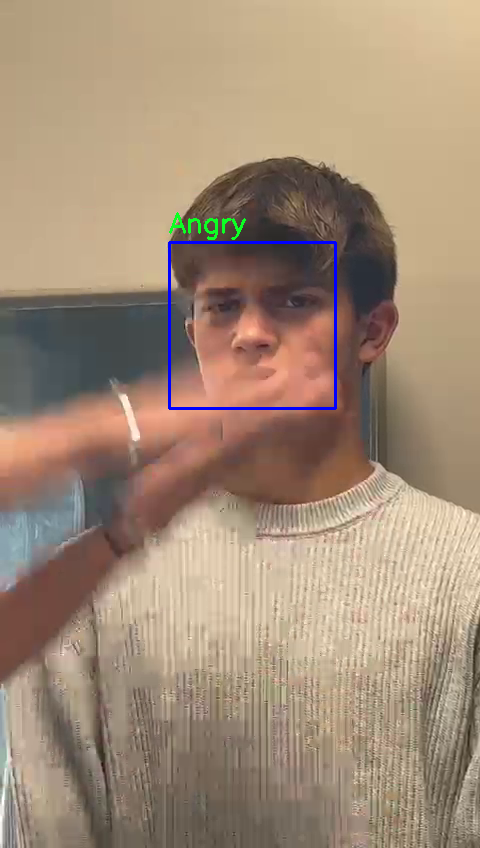

show frame


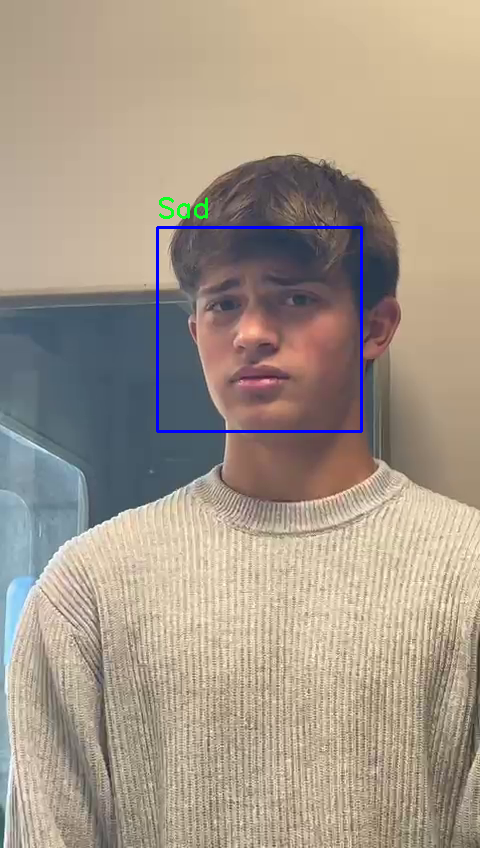

show frame


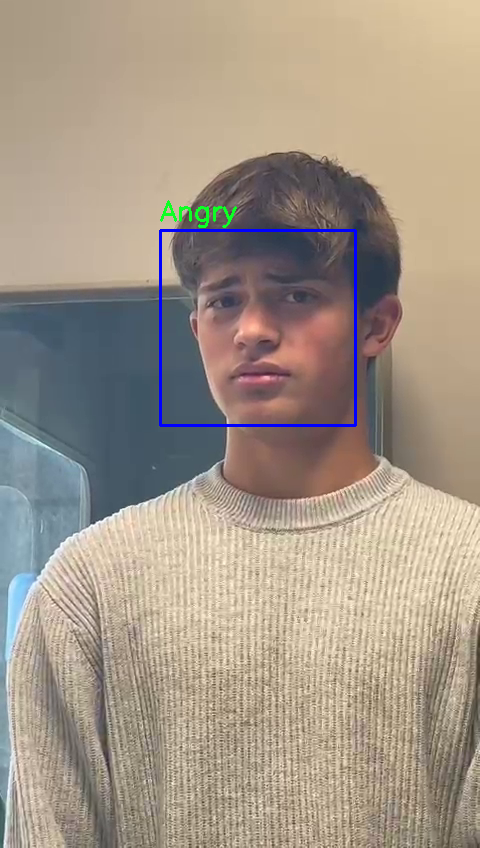

show frame


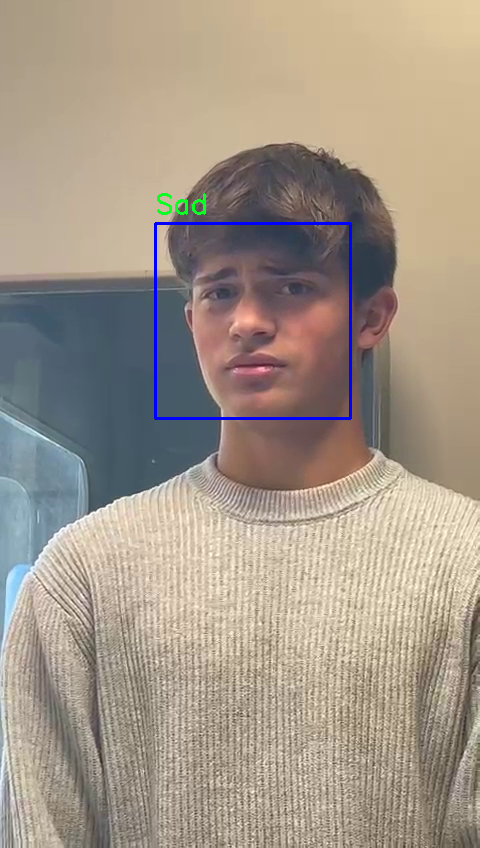

show frame


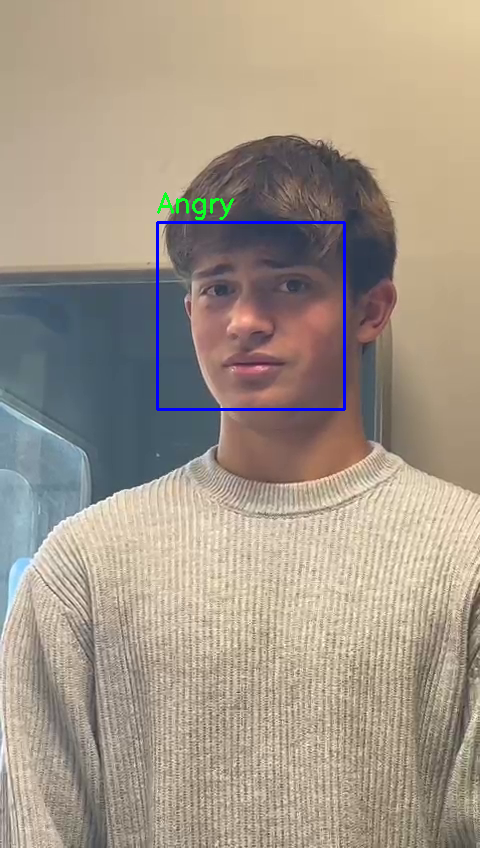

Eliot
show frame


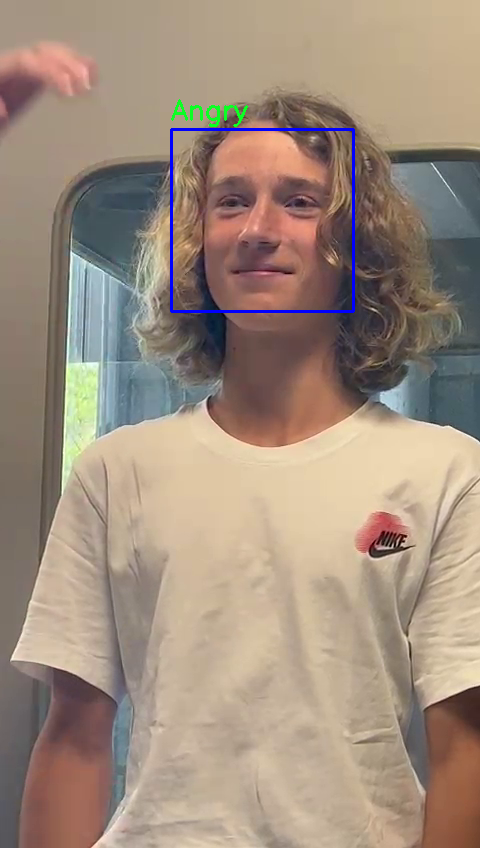

show frame


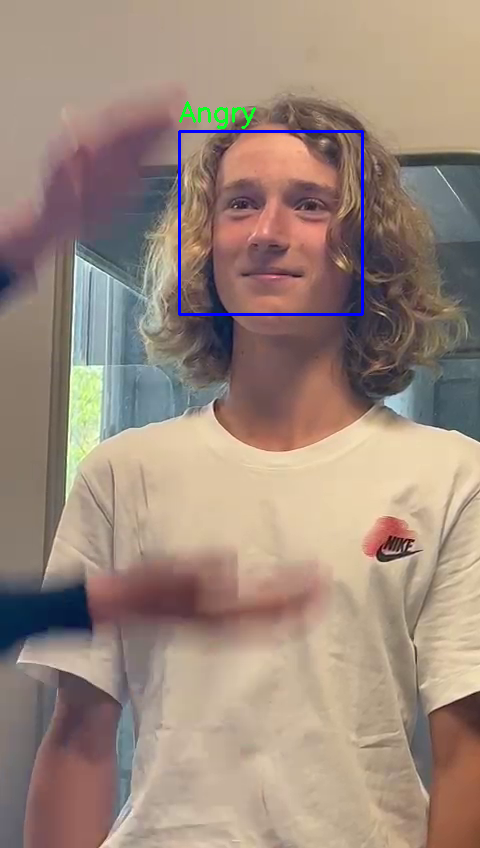

show frame


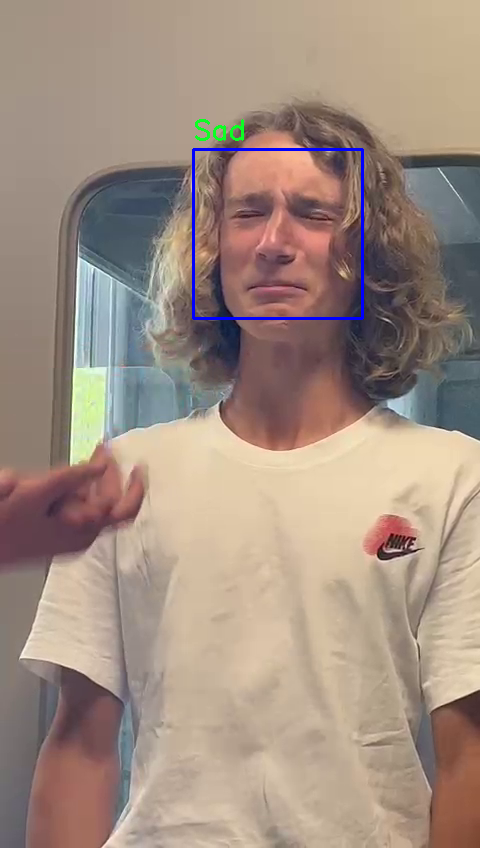

show frame


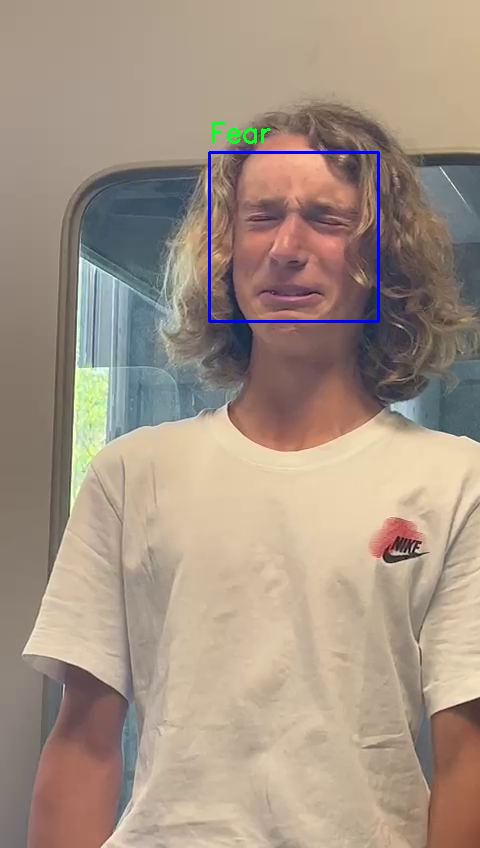

show frame


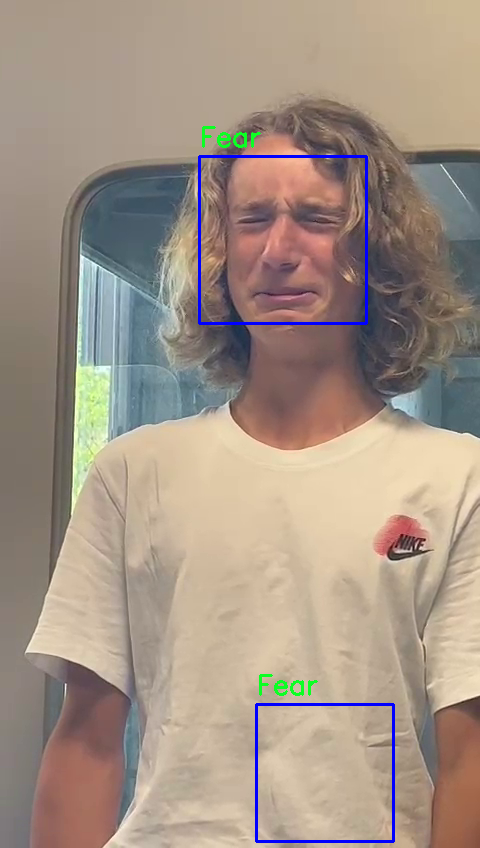

show frame


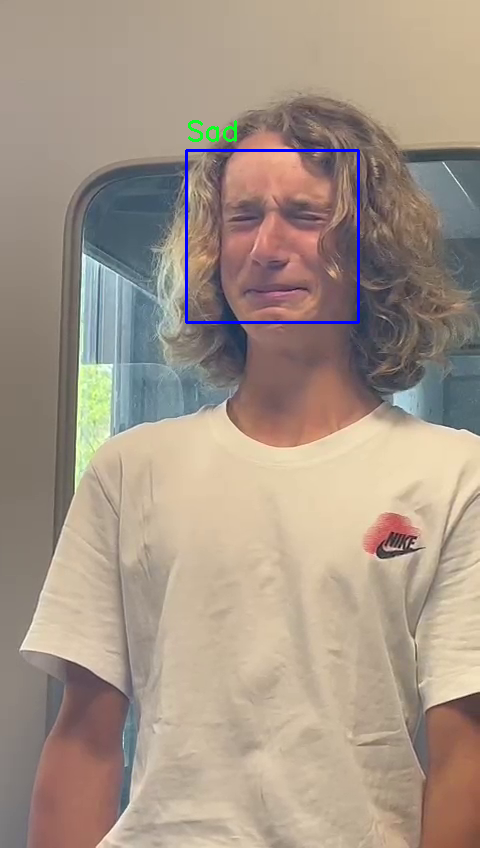

show frame


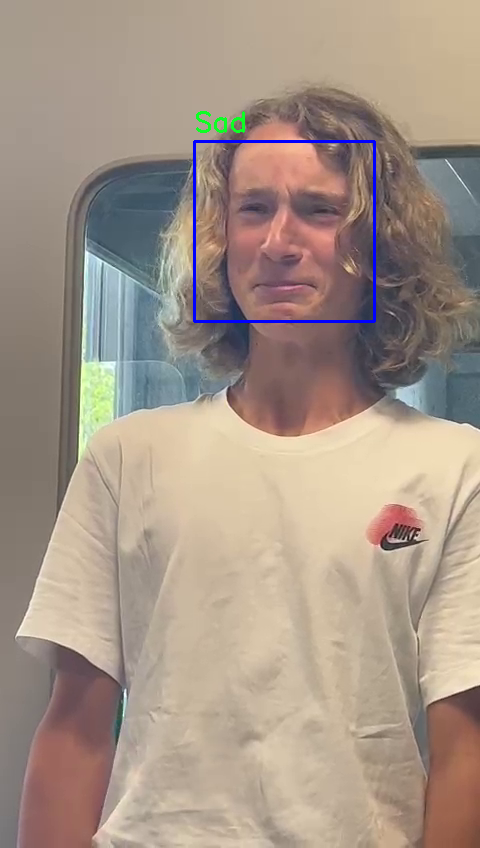

show frame


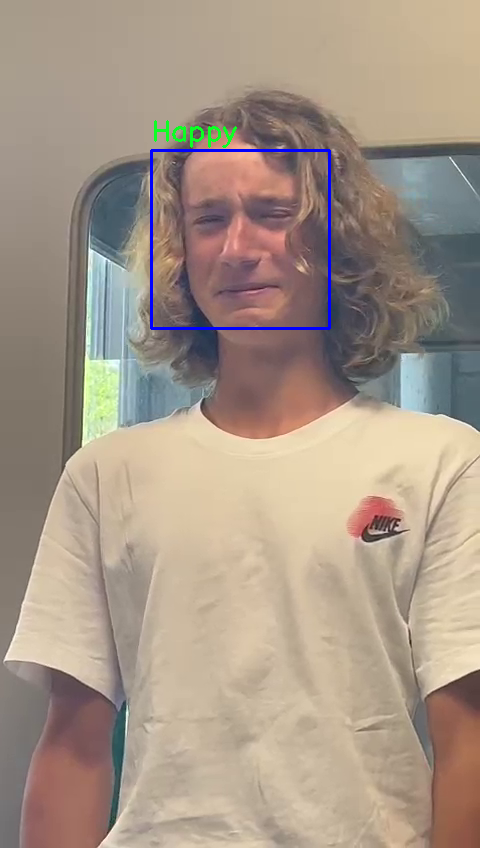

show frame


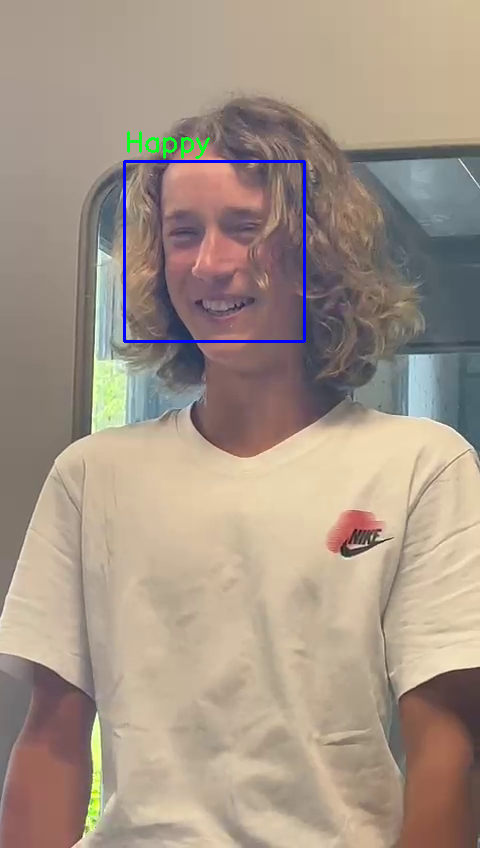

In [ ]:
print("Gregoire")
recogniseVideo('/content/drive/MyDrive/Deep Learning - faces/neutral.mp4')

print("Charles")
recogniseVideo('/content/drive/MyDrive/Deep Learning - faces/disgust.mp4')

print("Eliot")
recogniseVideo('/content/drive/MyDrive/Deep Learning - faces/sad.mp4')

# Function to extract the images from the feature maps

In [ ]:
def visualize_conv_layers(model, data_loader, num_rows=5, num_cols=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # lets get Conv2D layers and their weights
    conv_layers = []
    model_weights = []
    model_children = list(model.children())
    counter = 0
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
    print(f"Total convolution layers: {counter}")
    print(conv_layers)

    # get output and layer for processed image
    outputs = []
    names = []
    data_iter = iter(data_loader)
    image, label = next(data_iter)    # get one image and its label from the train_loader
    image = image.to(device)

    for layer in conv_layers[0:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    print("Feature maps:", len(outputs))
    print("Feature maps shape:")
    for feature_map in outputs:
        print(feature_map.shape)

    # converting 3d tensors to 2d
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.mean(feature_map[:, 0, :, :], dim=0)
        processed.append(gray_scale.data.cpu().numpy())
    print("Converted feature maps shape:")
    for fm in processed:
        print(fm.shape)

    # printing results
    fig = plt.figure(figsize=(15, 15))
    for i in range(len(processed)):
        a = fig.add_subplot(num_rows, num_cols, i + 1)
        imgplot = plt.imshow(processed[i])
        a.set_title(names[i].split('(')[0], fontsize=15)
        a.axis('off')

    plt.show()